In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [3]:
datapath = "/home/haue/repositories/Masters/data/"
iso = "P" 
_path = datapath + "bananas/" + iso
above_path = datapath+ "aboveban/" + iso
cuts1 = datapath + "cuts/totcuts.root"
outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
above_files = glob.glob(os.path.join(above_path, "*mlio.root"))

In [4]:
#### Loading in of the data files storing them in a dictionary
data_files = {
    "P": _files,
}
data_collection = {
    "P" : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing P: 100%|██████████ 63/63 [01:22<00:00,  1.32s/file]


In [104]:
totcuts = uproot.open(cuts1)

xsa =[]
ysa =[]
for i in ["abovebanU1", "abovebanU2", "abovebanU3"]:
    x, y = totcuts[i].values()
    xsa.append(np.array(x)/1e3)
    ysa.append(np.array(y)/1e3)
xs =[]
ys =[]
for i in ["bananaU1", "bananaU2", "bananaU3"]:
    
    x, y = totcuts[i].values()
    xs.append(np.array(x)/1e3)
    ys.append(np.array(y)/1e3)
   
in_fedep = []
in_bedep = []
in_E = []
above_events = []
above_fedep = []
above_bedep = []
above_E = []

isotope = iso
for k, i, j, l, h in zip(range(0,3),xs,ys, xsa, ysa):
    det = f"id{k}"
    inbanana = np.column_stack((i, j))
    abovebanana = np.column_stack((l, h))
    abovebanana_path = Path(abovebanana)
    inbanana_path = Path(inbanana)
    points = np.column_stack((data_collection[isotope][det]["bEdep"], data_collection[isotope][det]["fEdep"]))
    inmask = inbanana_path.contains_points(points)
    abovemask = abovebanana_path.contains_points(points)

    
    
    above_E.append(np.array(data_collection[isotope][det]["E"])[abovemask])
    above_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[abovemask])
    above_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[abovemask])
    in_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[inmask])
    in_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[inmask])
    in_E.append(np.array(data_collection[isotope][det]["E"])[inmask])
    above_events.append(len(above_fedep[k]))


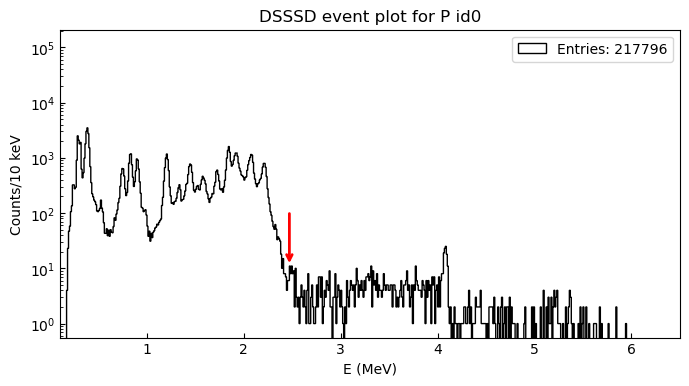

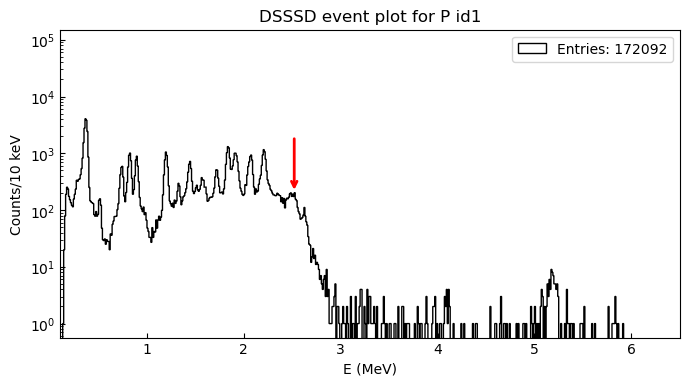

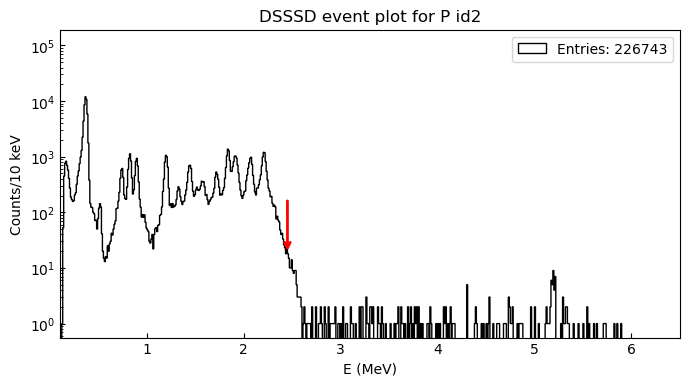

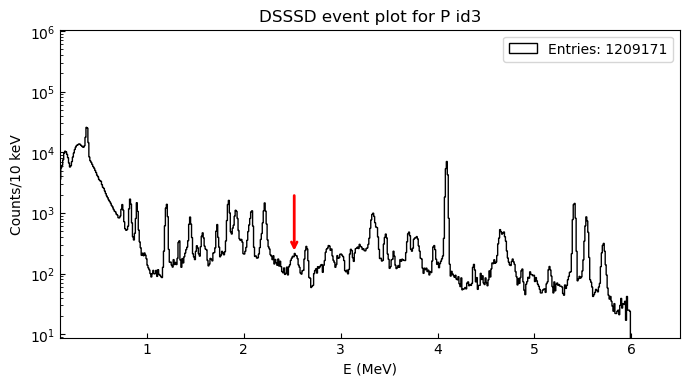

In [97]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

for i in range(4):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    e = np.array(data_collection[iso][det]["Edep"])
    e
    plt.hist(e, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts/10 keV")
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlim(0.1, 6.5)
    plt.title(f"DSSSD event plot for P {det}")
    bins = np.arange(0, 6, 0.01)
    counts, bin_edges = np.histogram(e, bins=bins)

    # Define the search region (modify as needed)
    search_min = 2.45  # Minimum energy to search for peak
    search_max = 2.55  # Maximum energy to search for peak

    # Find the indices corresponding to the search region
    search_indices = (bin_edges[:-1] >= search_min) & (bin_edges[:-1] <= search_max)

    # Extract the peak within this region
    peak_index = np.argmax(counts[search_indices])  # Index of max count within region
    peak_x = bin_edges[:-1][search_indices][peak_index]  # X-position of peak
    peak_y = counts[search_indices][peak_index]  # Y-position of peak

    # Set arrow position (halfway to 10^3)
    arrow_y_start = peak_y * 10
    arrow_y_end = peak_y  # Arrow points to the peak
    plt.annotate(
        '',  # Empty text, just for the arrow
        xy=(peak_x, arrow_y_end),  # Arrow points to the peak
        xytext=(peak_x, arrow_y_start),  # Arrow starts here
        arrowprops=dict(arrowstyle="->", color="red", lw=2),
    )
    plt.savefig(outputdir + f"DSSSDspec{det}.png")



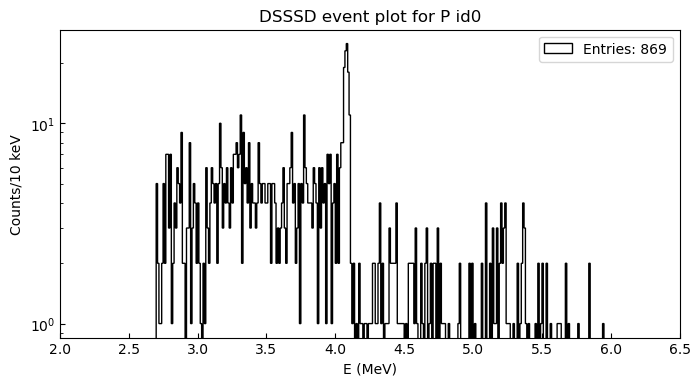

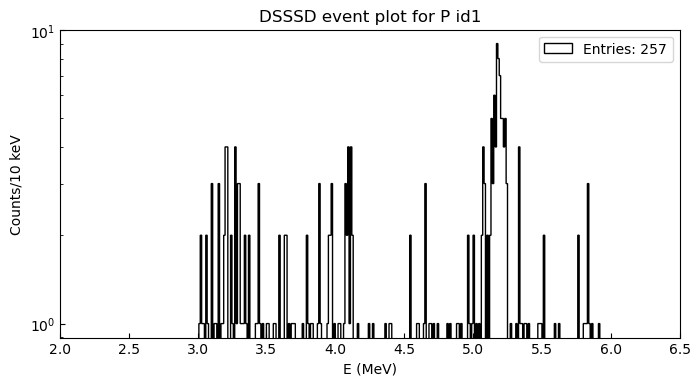

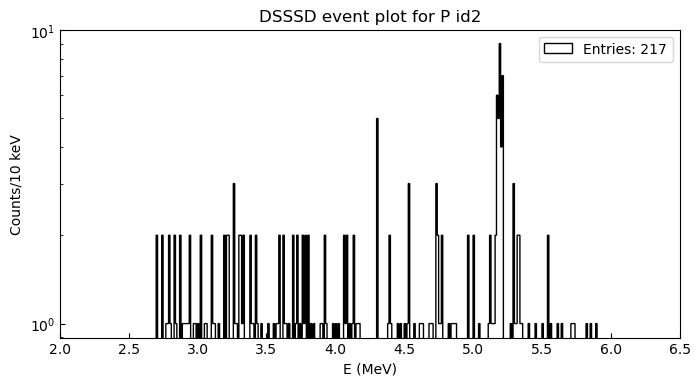

In [ ]:

for i in range(3):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    e = np.array(data_collection[iso][det]["Edep"])
    if det=="id1":
        e = e[e>3]
    else:
        e = e[e>2.7]
    plt.hist(e, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts/10 keV")
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlim(2, 6.5)
    plt.title(f"DSSSD event plot for P {det}")



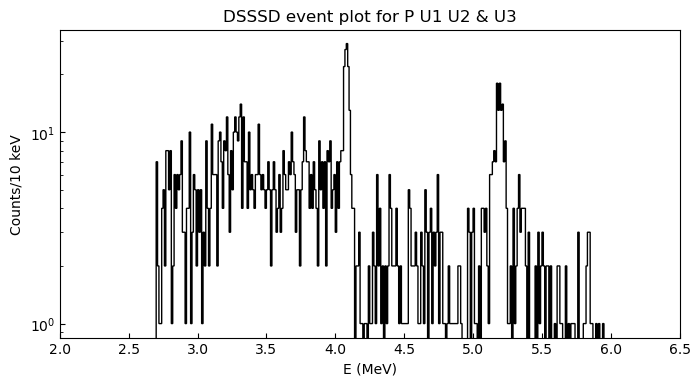

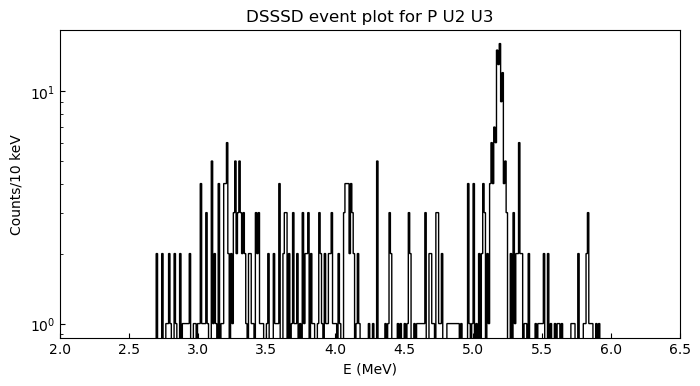

In [85]:
es = []
plt.figure(figsize=(8,4))
for i in range(3):
    det = f"id{i}"
    e = [j for j in data_collection[iso][det]["Edep"] if det=="id1" and j>3 or det!="id1" and j>2.7]
    es+=e
#e = e[e>0.5]
plt.hist(es, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 keV")
plt.yscale('log')
plt.xlim(2, 6.5)
plt.title(f"DSSSD event plot for P U1 U2 & U3")
plt.savefig(outputdir + "DSSSDeventall.png")

Es= []
plt.figure(figsize=(8,4))
for det in ["id1", "id2"]:
    for j in data_collection[iso][det]["Edep"]:
        if (det == "id2" and j > 2.7) or (det == "id1" and j > 3):
            Es.append(j)

#e = e[e>0.5]
plt.hist(Es, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 keV")
plt.yscale('log')
plt.xlim(2, 6.5)
plt.title(f"DSSSD event plot for P U2 U3")
plt.savefig(outputdir + "DSSSDevent12.png")




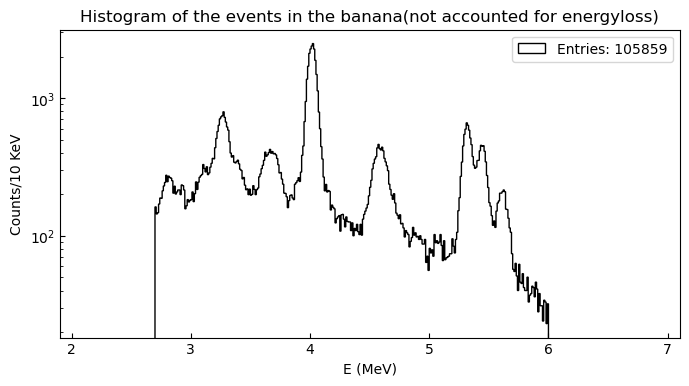

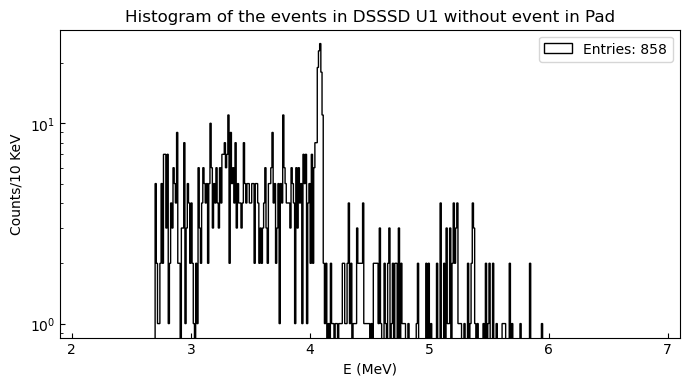

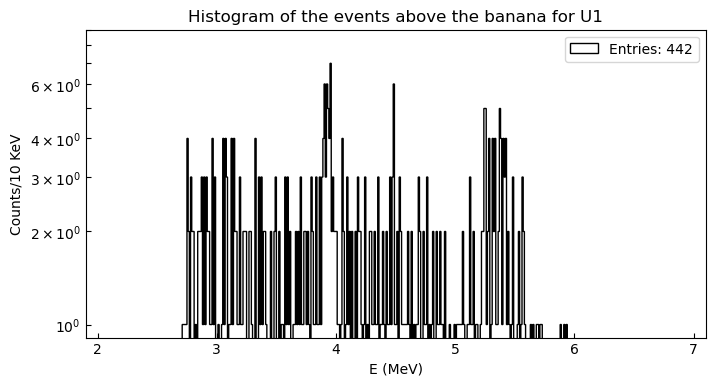

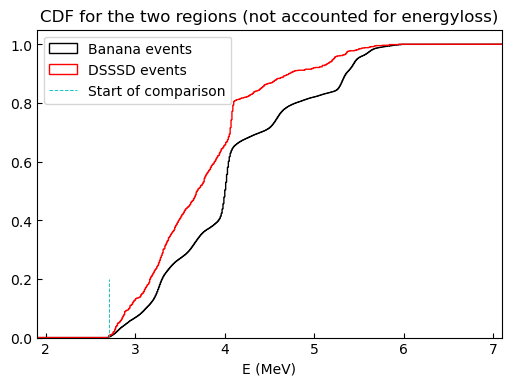

In [113]:
sumE = [a+b for a,b in zip(in_fedep[0], in_bedep[0]) if 6>a+b>2.7]
plt.figure(figsize=(8,4))
plt.hist(sumE, bins=np.arange(0,8,0.01), histtype='step', color='k', label=f"Entries: {len(in_E[0])}")
plt.yscale('log')
plt.title("Histogram of the events in the banana(not accounted for energyloss)")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')
plt.savefig(outputdir + "PU1bananahist.png")



#plt.show()
g = len(data_collection[iso]["id0"]["Edep"])
#plot of events recorded above the banana
sume = [a for a in data_collection[iso]["id0"]["Edep"] if 6>a>2.7]
plt.figure(figsize=(8,4))
plt.hist(sume, bins=np.arange(0, 8, 0.01), histtype='step', color='k', label=f"Entries: {len(sume)}")
plt.yscale('log')
plt.title("Histogram of the events in DSSSD U1 without event in Pad")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')

#plot of events recorded above the banana
abovesum = [a+b for a,b in zip(above_fedep[0], above_bedep[0]) if 6>a+b>2.7]
plt.figure(figsize=(8,4))
plt.hist(abovesum, bins=np.arange(0, 8, 0.01), histtype='step', color='k', label=f"Entries: {len(abovesum)}")
plt.yscale('log')
plt.title("Histogram of the events above the banana for U1")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')
plt.yticks(np.arange(1, 10, 1))

plt.figure(figsize=(6,4))
plt.hist(sumE, bins=np.arange(0,8,0.01), histtype='step', color='k', cumulative=True, label="Banana events", density=True)
plt.hist(sume, bins=np.arange(0,8,0.01), histtype='step', color='r', cumulative=True, label="DSSSD events", density=True)
plt.vlines(2.7, 0, 0.2, color='c', alpha=0.9, lw=0.7, ls='--', label="Start of comparison")
plt.xlabel("E (MeV)")
plt.legend(loc='upper left')
plt.xlim(0,8.5)
plt.xticks(np.arange(0,9,1))
plt.title("CDF for the two regions (not accounted for energyloss)")
plt.xlim(1.9, 7.1)
plt.savefig(outputdir + "CDFP.png")



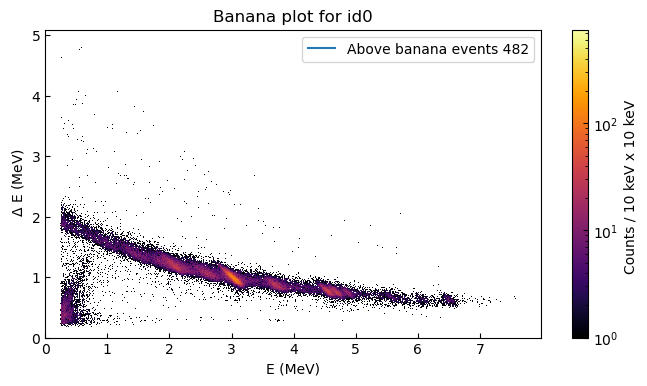

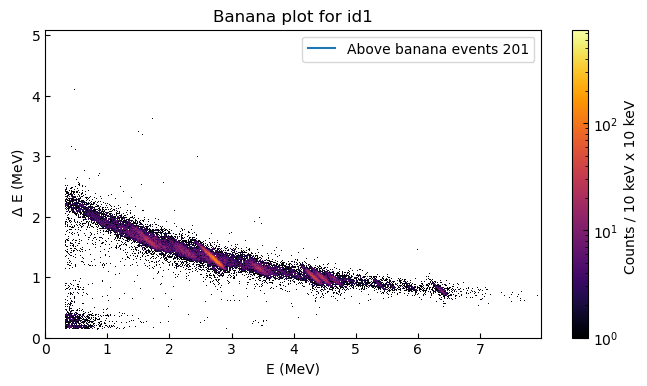

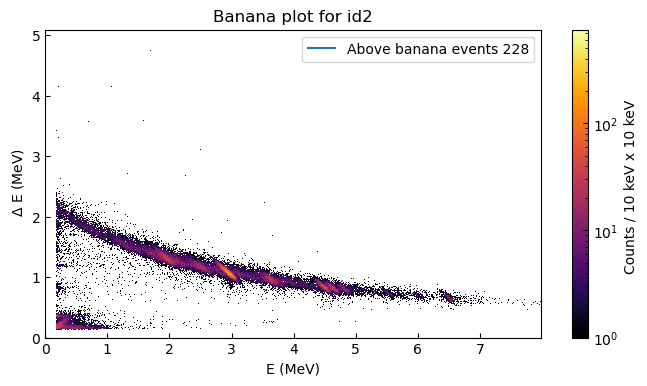

In [67]:
for i in range(3):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.plot([], [], label=f"Above banana events {above_events[i]}")
    plt.legend(loc='upper right')
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for {det}")


Entries with FI>8.5: 255
Entries with FI<8.5: 689
Entries with FI>8.5: 138
Entries with FI<8.5: 119
Entries with FI>8.5: 113
Entries with FI<8.5: 112


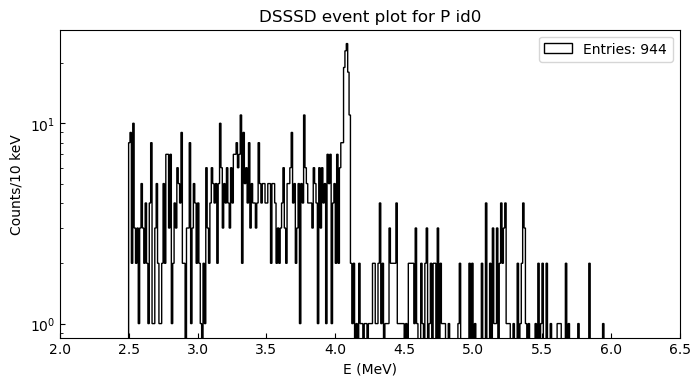

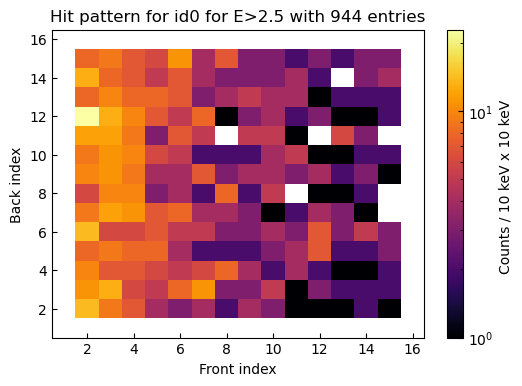

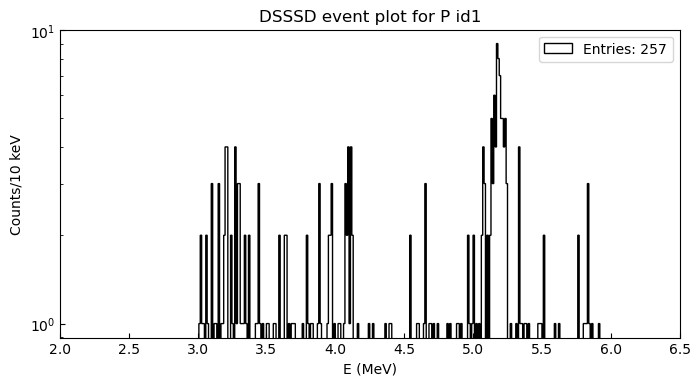

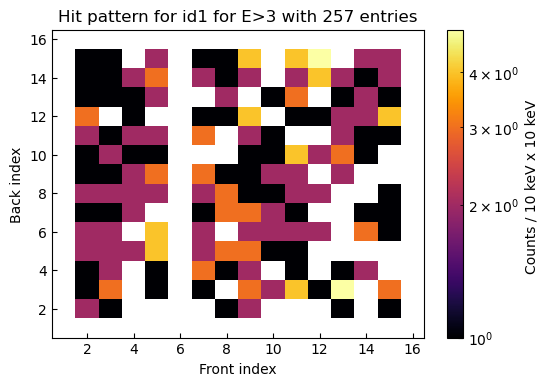

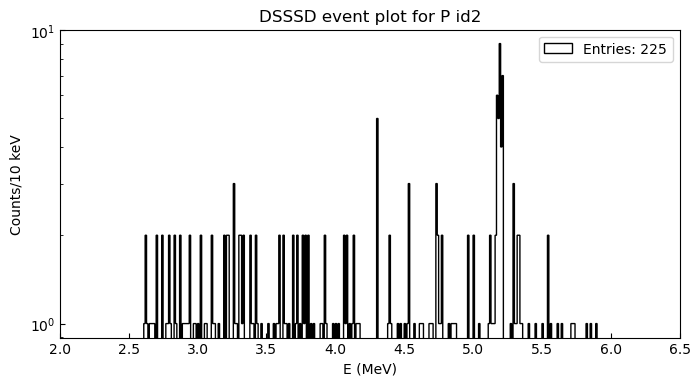

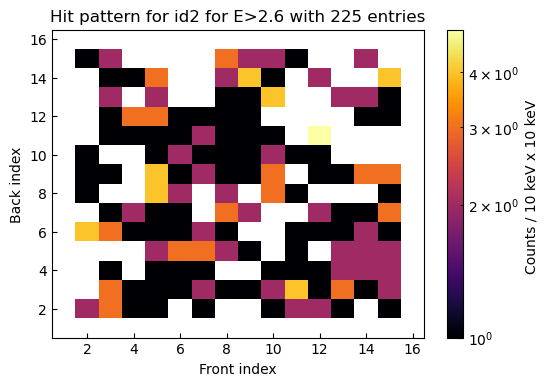

In [103]:

for i in range(3):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    e = np.array(data_collection[iso][det]["Edep"])
    fi = np.array(data_collection[iso][det]["FI"])
    bi = np.array(data_collection[iso][det]["BI"])
    if det=="id1":
        lim = 3
        mask = (e>lim)
        e = e[mask]
        fi = fi[mask]
        bi = bi[mask]
    if det =="id0":
        lim = 2.5
        mask = (e>lim)
        e = e[mask]
        fi = fi[mask]
        bi = bi[mask]
    if det=="id2":
        lim = 2.6
        mask = (e>lim)
        e = e[mask]
        fi = fi[mask]
        bi = bi[mask]    
    plt.hist(e, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts/10 keV")
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlim(2, 6.5)
    plt.title(f"DSSSD event plot for P {det}")
    plt.figure(figsize=(6,4))
    plt.hist2d(fi-0.5, bi-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for {det} for E>{lim} with {len(fi)} entries")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.savefig(outputdir + f"hitpat{det}.png")
    fo = [f for f in fi if f>8.5]
    fu = [f for f in fi if f<8.5] 
    print(f"Entries with FI>8.5: {len(fo)}")
    print(f"Entries with FI<8.5: {len(fu)}")
        

